In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 의도

: 기존에 매출이 없는 달이 있으면 해당 분기를 제외하고 예측을 했었다. 이러한 정보 손실을 보완하기 위해 분기당 평균 매출액으로 문제를 재구성하여 예측을 시도했다. 타겟 값이 부정확해지므로 더 안좋은 결과가 나올 수도 있다.



In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 통계분석
import scipy.stats as stats
import urllib
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
%matplotlib inline

# 
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit

In [0]:
train = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/funda_train.csv')
submission = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/submission.csv')

# 분석 전에 데이터 처리
 - Dacon 질의응답 내용을 바탕으로 미리 이상한 데이터 처리

### 월매출이 없는 경우



In [0]:
month_check = quarter(train)
month_check['year'] = np.where(month_check['month']==12, month_check['year']+1, month_check['year'])

In [0]:
quarter_check = month_check.groupby(['store_id','year','quarter','month']).count().reset_index()
quarter_check = quarter_check.groupby(['store_id','year','quarter']).count()[['month']].reset_index()

In [0]:
print(quarter_check[quarter_check['month']!=3].shape[0], quarter_check[quarter_check['month']!=3].store_id.nunique())
print(quarter_check[quarter_check['month']==2].shape[0], quarter_check[quarter_check['month']==2].store_id.nunique())
print(quarter_check[quarter_check['month']==1].shape[0], quarter_check[quarter_check['month']==1].store_id.nunique())

792 584
457 358
335 306


# EDA

## 3개월 단위로 압축

**3개월 분기 컬럼 생성 함수**


In [0]:
def quarter(data):
  data2 = data.copy()
  data2['quarter'] = np.where((data2.month==12) | (data2.month<=2), 1,                     # 1: 12~1월
                            np.where((data2.month<6) & (data2.month>=3),2,                # 2: 3~5월
                                     np.where((data2.month<9) & (data2.month>=6), 3, 4))) # 3: 6~8월,   4: 9~11월
      
  return data2

In [0]:
!pip install workalendar
from workalendar.asia import SouthKorea # 한국의 공휴일, version : 1.1.1

     |████████████████████████████████| 174kB 5.0MB/s 
     |████████████████████████████████| 245kB 48.0MB/s 
     |████████████████████████████████| 16.0MB 206kB/s 
  Created wheel for skyfield: filename=skyfield-1.16-cp36-none-any.whl size=273609 sha256=4957f60d923523602285944b289e11a2b0003bb3165c27bd5750b6b123f7e514
  Stored in directory: /root/.cache/pip/wheels/4b/27/4c/29aa7d60909618f39aca67c7170969e2ec6a8c7aebe0c1a455
  Created wheel for pyCalverter: filename=pyCalverter-1.6.1-cp36-none-any.whl size=4200 sha256=6365458ec94b05dbde8df5d949f43251a2cb1dfe007e2925f201b25c06b95d7c
  Stored in directory: /root/.cache/pip/wheels/77/4d/86/db4ff4eca6178dbbd5a365d095f97f6021e2a48f09908be79c
  Created wheel for jplephem: filename=jplephem-2.12-cp36-none-any.whl size=43929 sha256=9b08cb3746b64b0024a0ad09b96981644d1d14a2132aaf08a892ece78e8ea336
  Stored in directory: /root/.cache/pip/wheels/08/ce/59/bde14a0c20cdfb538a28d78fec79dd628c8d03d5a75f812d1a
  Created wheel for sgp4: filename=sgp4-1.4

In [0]:
# 시간 변수 생성
# https://dacon.io/index.php?mid=code1&category=217514&document_srl=254639
holidays = pd.concat([pd.Series(np.array(SouthKorea().holidays(2019))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2018))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2017))[:, 0]),
                      pd.Series(np.array(SouthKorea().holidays(2016))[:, 0])]).reset_index(drop=True)

times = train[['transacted_date','transacted_time']].drop_duplicates()
times['date2'] = times['transacted_date']
times['time2'] = times['transacted_time']

times['date2'] = pd.to_datetime(times['date2'])
times['year'] = times['date2'].dt.year
#times['year'] = 2019 - times['year'] 
times['month'] = times['date2'].dt.month
times['weekday'] = times['date2'].dt.weekday
times['is_holiday']= times['date2'].dt.date.isin(holidays).astype(int)

times['time2'] = pd.to_datetime(times['time2'])
times['hour'] = times['time2'].dt.hour

del times['date2']
del times['time2']

train = pd.merge(train,times, on=['transacted_date','transacted_time'])

## 압축 전의 변수 생성

### 4. installment_term
- 할부 60개월 이상은 포인트
- 포인트 사용은 고정 고객 판단에 대한 지표가 될 수 있음

### 5. amount

파생변수
- 환불/취소 여부 카운트

In [0]:
train['is_point'] = np.where(train['installment_term']>=60, 1, 0)
train['installment_term'] = np.where(train['installment_term']>=60, train['installment_term'] - 60, train['installment_term'])
train['refund'] = np.where(train['amount']<0, 1, 0)

In [0]:
# 3개월 다운샘플링
train2 = quarter(train)
train2['year'] = np.where(train2['month']==12, train2['year']+1, train2['year'])
train2 = train2.groupby(['store_id','year','quarter','month']).sum().reset_index() # 월단위 합
train2 = train2.groupby(['store_id','year','quarter']).mean() # 분기 단위 평균
train2 = train2.drop(['card_id','month','weekday','hour'],axis=1).reset_index()

In [0]:
train2.head(), train2.shape

(   store_id  year  quarter  ...  is_holiday  is_point    refund
 0         0  2016        3  ...    4.000000  0.333333  0.666667
 1         0  2016        4  ...    5.333333  0.000000  1.000000
 2         0  2017        1  ...    2.333333  0.000000  0.000000
 3         0  2017        2  ...    7.333333  0.000000  0.000000
 4         0  2017        3  ...    0.000000  0.000000  0.333333
 
 [5 rows x 8 columns], (20453, 8))

## 1. region
- 띄어쓰기 기준으로 행정구역을 나눠 파생변수 생성.
- 도시별로 구매력 trend를 나타내는 파생변수 생성

In [0]:
# region 변수 나누기
region = train[['store_id','region']].drop_duplicates()
region['region2']= region['region'].str.partition(' ')[0]
region['region3']= region['region'].str.partition(' ')[2]

In [0]:
region.head()

,store_id,region,region2,region3
0,0,NaN,NaN,NaN
1,117,경기 시흥시,경기,시흥시
2,363,인천 서구,인천,서구
3,524,서울 중랑구,서울,중랑구
4,706,대전 중구,대전,중구


In [0]:
train2 = pd.merge(train2, region, on='store_id')

**분기별, 지역의 구매력 trend**

In [0]:
# region3는 가게 수가 적은 지역이 많으므로, 대표성을 위해 region2로 분석
region_trend = train[['region','year','month','amount','store_id']]
region_trend = pd.merge(region_trend, region.drop('store_id',axis=1).drop_duplicates(), on='region').drop('region',axis=1).dropna(axis=0)
region_trend = quarter(region_trend)
region_trend['year'] = np.where(region_trend['month']==12, region_trend['year']+1, region_trend['year'])

세종(4)를 제외하고 31 이상의 가게를 갖고 있으므로 대표성 확보 가능

In [0]:
region_trend[['region2','store_id']].drop_duplicates().groupby('region2').count()['store_id']

region2
강원     44
경기    303
경남     95
경북     71
광주     41
대구     63
대전     36
부산    101
서울    189
세종      4
울산     37
인천     64
전남     39
전북     42
제주     31
충남     57
충북     60
Name: store_id, dtype: int64

In [0]:
region_trend_amt = region_trend.groupby(['region2','year','quarter','month']).sum().reset_index() # 월별 지역 매출 합
region_trend2 = region_trend_amt.groupby(['region2','year','quarter']).mean().reset_index().sort_values(by=['year','quarter'], ascending=[False, True]) # 분기별 지역 매출 평균
region_trend_count = region_trend.groupby(['region2','year','quarter','month']).count().reset_index() # 월별 지역 결제빈도
region_trend2['num_count'] = region_trend_count.groupby(['region2','year','quarter']).mean().reset_index().sort_values(by=['year','quarter'], ascending=[False, True])['store_id'] # 분기별 지역 결제빈도 평균

region_trend2['amt_per_region2'] = region_trend2['amount'] / region_trend2['num_count'] # 지역 구매력

region_trend2 = region_trend2.drop(['month','store_id','num_count'],axis=1)
region_trend2.columns = ['region2','year','quarter','region2_amt','amt_per_region2']

In [0]:
region_trend2.head()

,region2,year,quarter,region2_amt,amt_per_region2
10,강원,2019,1,5.636734e+07,12379.356442
21,경기,2019,1,3.365753e+08,11672.323246
32,경남,2019,1,9.367309e+07,8021.787916
43,경북,2019,1,7.550174e+07,10476.168209
54,광주,2019,1,4.133623e+07,15082.545627


지역 정보가 없는 가게를 위해 전국 단위 경제 trend 변수 생성

In [0]:
region_trend_amt = region_trend.groupby(['year','quarter','month']).sum().reset_index() # 월별 매출 총합
region_trend3 = region_trend_amt.groupby(['year','quarter']).mean().reset_index()
region_trend_count = region_trend.groupby(['year','quarter','month']).count().reset_index() # 월별 결제빈도
region_trend3['num_count'] = region_trend_count.groupby(['year','quarter']).mean().reset_index()['store_id'] # 결제빈도

region_trend3['amt_per_quarter'] = region_trend3['amount'] / region_trend3['num_count'] # 전국 구매력

region_trend3 = region_trend3.drop(['month','store_id','num_count'],axis=1)
region_trend3.columns = ['year','quarter','quarter_amt','amt_per_quarter']

del region_trend_amt
del region_trend_count

In [0]:
region_trend2 = pd.merge(region_trend2, region_trend3, on=['year','quarter'])
del region_trend3

In [0]:
region_trend2.head()

,region2,year,quarter,region2_amt,amt_per_region2,quarter_amt,amt_per_quarter
0,강원,2019,1,5.636734e+07,12379.356442,1.473806e+09,11482.55922
1,경기,2019,1,3.365753e+08,11672.323246,1.473806e+09,11482.55922
2,경남,2019,1,9.367309e+07,8021.787916,1.473806e+09,11482.55922
3,경북,2019,1,7.550174e+07,10476.168209,1.473806e+09,11482.55922
4,광주,2019,1,4.133623e+07,15082.545627,1.473806e+09,11482.55922


In [0]:
train2 = pd.merge(train2, region_trend2, on=['year','quarter','region2'], how='outer')

In [0]:
train2.shape

(20453, 15)

## 5. amount

파생변수
- 최소 결제금액(최소 판매단가)
- 평균 결제금액

건당 결제금액의 변화가 시간에 따라 발생할까?

In [0]:
amount = train[['year','month','store_id','amount']]
amount = quarter(amount)
amount['year'] = np.where(amount['month']==12, amount['year']+1, amount['year'])
# 가게별 건당 결제금액 평균
amount_mean =  amount.groupby(['year','quarter','store_id']).mean().reset_index().drop('month', axis=1)
amount_mean.columns = ['year','quarter','store_id','mean_purchase']
# 가게별 건당 결제금액 최솟값(최소 단위)
amount_min =  amount[amount.amount>=0].groupby(['year','quarter','store_id']).min().reset_index().drop('month', axis=1)
amount_min.columns = ['year','quarter','store_id','min_price']

# 병합
amount = amount.drop(['amount','month'],axis=1).drop_duplicates()
amount = pd.merge(amount, amount_mean, on=['year','quarter','store_id'])
amount = pd.merge(amount, amount_min, on=['year','quarter','store_id'])

In [0]:
amount.head(), amount.shape

(   year  store_id  quarter  mean_purchase   min_price
 0  2016         0        3    5310.873337  142.857143
 1  2016       117        3    5800.536273  142.857143
 2  2016       363        3    3904.118404  285.714286
 3  2016       524        3    5529.292073  357.142857
 4  2016       706        3    1226.181423   71.428571, (20453, 5))

In [0]:
train2 = pd.merge(train2, amount, on=['year','quarter','store_id'], how='outer')
train2.shape

(20453, 17)

## 2. type_of_business
- region과 같이 파생변수 생성

In [0]:
type_of_business = train[['store_id','type_of_business']].drop_duplicates().dropna()
a = type_of_business['type_of_business'].str.split(' ')
values3 = []
for i in range(a.shape[0]):
  values3.append(a.iloc[i][-1])

type_of_business['type_of_business3'] =values3
type_of_business['type_of_business3'] = np.where((type_of_business['type_of_business3'].str.slice(start=-2)=='학원'),
                                                 '학원', type_of_business['type_of_business3']) # 예외처리
type_of_business['type_of_business3'] = np.where((type_of_business['type_of_business3'].str.slice(start=-3)=='전문점'),
                                                 '음식점업', type_of_business['type_of_business3']) # 예외처리                                                

In [0]:
type_of_business.head(), type_of_business.shape

(    store_id type_of_business type_of_business3
 0          0           기타 미용업               미용업
 1        117          한식 음식점업              음식점업
 2        363           두발 미용업               미용업
 10      1597          한식 음식점업              음식점업
 11      2060          일식 음식점업              음식점업, (792, 3))

In [0]:
train2 = pd.merge(train2, type_of_business, on='store_id', how='outer')
train2.shape

(20453, 19)

In [0]:
# type_of_business3로 분석
business_trend = train[['type_of_business','year','month','amount','store_id']]
business_trend = pd.merge(business_trend, type_of_business.drop('store_id',axis=1).drop_duplicates(), on='type_of_business').drop('type_of_business',axis=1).dropna(axis=0)
business_trend = quarter(business_trend)
business_trend['year'] = np.where(business_trend['month']==12, business_trend['year']+1, business_trend['year'])

business_trend_amt = business_trend.groupby(['type_of_business3','year','quarter','month']).sum().reset_index() # 월별 업종 매출 합
business_trend2 = business_trend_amt.groupby(['type_of_business3','year','quarter']).mean().reset_index().sort_values(by=['year','quarter'], ascending=[False, True]) # 분기별 업종 매출 평균

business_trend_count = business_trend.groupby(['type_of_business3','year','quarter','month']).count().reset_index() # 월별 업종 결제빈도
business_trend2['num_count'] = business_trend_count.groupby(['type_of_business3','year','quarter']).mean().reset_index().sort_values(by=['year','quarter'], ascending=[False, True])['store_id'] # 결제빈도

business_trend2['amt_per_business3'] = business_trend2['amount'] / business_trend2['num_count'] # 지역 구매력

business_trend2 = business_trend2.drop(['month','store_id','num_count'],axis=1)
business_trend2.columns = ['type_of_business3','year','quarter','business3_amt','amt_per_business3']

del business_trend_count
del business_trend_amt

In [0]:
train2 = pd.merge(train2, business_trend2, on=['year','quarter','type_of_business3'], how='outer')
train2.shape

(20453, 21)

## 3. transacted_date,	transacted_time
- 연,월,요일,공휴일,시간 생성

**오전, 저녁, 야간 영업 유무 파악**
- 24시간을 모두 변수로 만들면 차원이 커지는 반면, 영업시간은 대체로 업종별로 통일된 경우가 많아 정보의 가치는 떨어지므로 4개의 범주로 처리한다. 

In [0]:
working_hour = train.groupby(['store_id','hour']).count()[['amount']].reset_index()

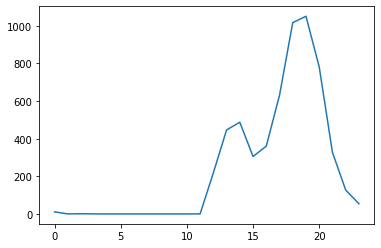

In [0]:
# 영업시간별 결제횟수 그래프 = 영업시간을 파악할 수 있음
i = 4
plt.plot(working_hour[working_hour['store_id']==i]['hour'], working_hour[working_hour['store_id']==i]['amount'])

In [0]:
working_hour['open_time'] = np.where((working_hour['hour']<=7) | (working_hour['hour']==23), 0, # 새벽
                                     np.where((working_hour['hour']>7) & (working_hour['hour']<=12), 1, # 오전
                                               np.where((working_hour['hour']>12) & (working_hour['hour']<=20),2, # 오후,저녁
                                                                                                               3))) # 늦은 저녁(21~23시)
working_hour = pd.get_dummies(working_hour, columns=['open_time']) # 영업시간을 더미변수화
working_hour = working_hour.groupby('store_id').sum().drop(['hour','amount'], axis=1).reset_index() # 영업시간 이외 컬럼 제거

for i in range(4):
  working_hour['open_time_' + str(i)] = np.where(working_hour['open_time_' + str(i)]>=1, 1 ,0) # open_time을 1,0으로 변경                       

In [0]:
working_hour.head()

,store_id,open_time_0,open_time_1,open_time_2,open_time_3
0,0,1,1,1,1
1,1,0,1,1,0
2,2,1,1,1,0
3,4,1,1,1,1
4,5,0,1,1,1


In [0]:
train2 = pd.merge(train2, working_hour, on='store_id')

**요일별 결제금액**
- 평일,주말로 나눠서 매출에 차이가 있을까
- 예를 들어, 주매출이 주말인 가게의 다음 분기 매출액의 변동이 적은가?

In [0]:
weekday_amt = train.groupby(['store_id','weekday']).sum()[['amount']].reset_index()
weekday_amt['weekend'] = np.where(weekday_amt['weekday']>=5, 1, 0)
weekday_amt['saturday'] = np.where(weekday_amt['weekday']==5, 1, 0)
weekday_amt['sunday'] = np.where(weekday_amt['weekday']==6, 1, 0)

weekday_amt = weekday_amt.groupby(['store_id','weekend']).mean().reset_index()
weekday_amt['amount_diff'] = np.where(weekday_amt['weekend']==0, weekday_amt['amount']*(-1), weekday_amt['amount']) # 주말, 평일 평균 차이 계산을 위해 평일매출은 음수로 변경 
weekday_amt = pd.get_dummies(weekday_amt, columns=['weekend'],prefix='open').groupby('store_id').sum().reset_index() # 주말, 평일 오픈 여부를 더미변수화
weekday_amt['open_5'] = np.where(weekday_amt['saturday']==0, 0, 1) # 토요일 오픈여부 변수 생성
weekday_amt['open_6'] = np.where(weekday_amt['sunday']==0, 0, 1) # 일요일 오픈여부 변수 생성

weekday_amt['weekend_store'] = np.where(weekday_amt['amount_diff']>0,1,0) # 주말 평균 매출이 더 높은 가게 변수 생성
weekday_amt = weekday_amt[['store_id','weekend_store','open_0','open_5','open_6']]
weekend_store = weekday_amt[weekday_amt['weekend_store']==1]['store_id'] # 주말 평균 매출이 더 높은 가게들 리스트

In [0]:
train2 = pd.merge(train2, weekday_amt, on='store_id')

주말에 매출이 높은 가게들의 매출액 평균과 표준편차가 평일 가게의 2분의 1 수준이므로,
의사결정나무에서 유의미한 분기 기준이 될 수 있음 

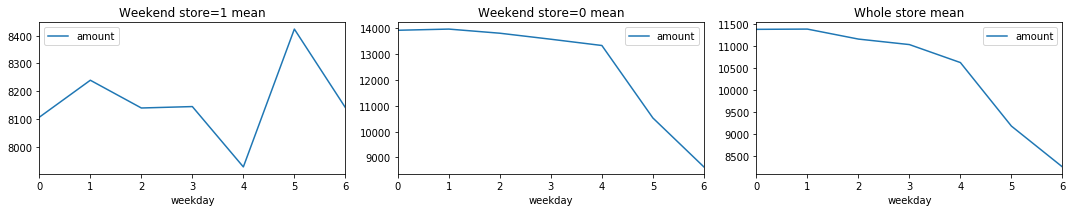

In [0]:
# Weekend store 여부에 따른 매출액 mean 비교
plt.figure(figsize=(15,8))
ax1 = plt.subplot(3,3,1)
ax2 = plt.subplot(3,3,2)
ax3 = plt.subplot(3,3,3)
train.loc[train['store_id'].isin(weekend_store)].groupby(['weekday']).mean()[['amount']].plot(ax=ax1)
train.loc[train['store_id'].isin(weekend_store)==False].groupby(['weekday']).mean()[['amount']].plot(ax=ax2)
train.groupby(['weekday']).mean()[['amount']].plot(ax=ax3)
ax1.set_title('Weekend store=1 mean')
ax2.set_title('Weekend store=0 mean')
ax3.set_title('Whole store mean')
plt.tight_layout()

**계절성 여부** (seasonal_p)
- 분기별로 매출액 표준편차가 차이 존재 --> 특히 3-5월에 낮음
- 분기별 매출액 평균은 p==0이므로 유의미한 차이  --> 특히 3-5월에 낮음
- 따라서 계절성 여부를 나누는 변수는 유의미한 정보가 있음
    - 가게별로 계절성 변수는 p value로 구하는데, 분기 단위 데이터가 적으므로 일단위 매출액으로 계절성 비교할 것임

In [0]:
# 분기별 매출액 비교를 위한 df
seasonal_amt = train[['store_id','month','amount']]
seasonal_amt = quarter(seasonal_amt)
del seasonal_amt['month']

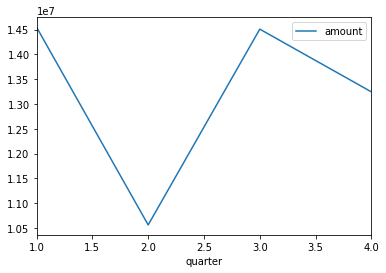

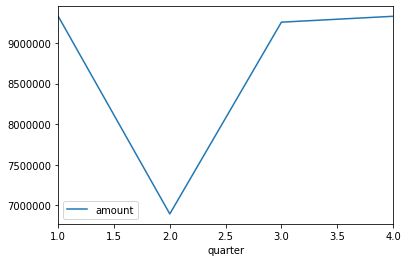

In [0]:
# 분기별 가게들의 매출액
seasonal_amt = seasonal_amt.groupby(['store_id','quarter']).sum()[['amount']].reset_index()
# 분기별 매출액 표준편차,평균 비교 그래프
seasonal_amt.groupby(['quarter']).std()[['amount']].plot()
seasonal_amt.groupby(['quarter']).mean()[['amount']].plot()

In [0]:
# 계절성 p value 구하는 함수
def seasonal_p_value(x):
  import warnings
  warnings.filterwarnings('ignore')
  
  d = {}
  df = pd.DataFrame(x, columns=['quarter', 'amount'])    

  # the "C" indicates categorical data
  model = ols('amount ~ C(quarter)', df).fit()
  d['seasonal_p'] = model.f_pvalue
  return pd.Series(d, index=['seasonal_p'])

In [0]:
seasonal_p = train[['store_id','transacted_date','month','year','amount']]
seasonal_p['transacted_date'] = pd.to_datetime(seasonal_p['transacted_date'])
seasonal_p['day'] = seasonal_p['transacted_date'].dt.day
seasonal_p = seasonal_p.groupby(['store_id','year','month','day']).sum().reset_index() # amount를 일단위로 다운샘플링
seasonal_p = quarter(seasonal_p).drop(['year','month','day'],axis=1)

seasonal_p = seasonal_p.groupby('store_id').apply(seasonal_p_value).reset_index()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
seasonal_p.head(3)

,store_id,seasonal_p
0,0,0.434025
1,1,0.006937
2,2,0.461739


In [0]:
train2 = pd.merge(train2, seasonal_p, on='store_id')

**분기별 영업일수 대비 구매빈도** (action_per_day)
 - 이동환님의 아이디어 참조

In [0]:
store_date_custom = train[['store_id','transacted_date','month','year']]
store_date_custom['transacted_date'] = pd.to_datetime(store_date_custom['transacted_date'])
store_date_custom['day'] = store_date_custom['transacted_date'].dt.day
store_date_custom = store_date_custom.groupby(['store_id','year','month','day']).count().reset_index() # amount를 일단위로 다운샘플링

store_date_custom =quarter(store_date_custom) # 분기 계산
store_date_custom['year'] = np.where(store_date_custom['month']==12, store_date_custom['year']+1, store_date_custom['year']) 

store_date_custom_act = store_date_custom.groupby(['store_id','year','quarter','month']).sum() # 월별 결제횟수 합
store_date_custom2 = store_date_custom_act.groupby(['store_id','year','quarter']).mean() # 분기별 결제횟수 평균

store_date_custom_open = store_date_custom.groupby(['store_id','year','quarter','month']).count() # 월별 영업일수
store_date_custom2['day_count'] = store_date_custom_open.groupby(['store_id','year','quarter']).mean()['day'] # 분기별 영업일수 평균

store_date_custom2['action_per_day'] = store_date_custom2['transacted_date'] / store_date_custom2['day_count'] # 구매빈도 평균 / 영업일수 평균
store_date_custom2 = store_date_custom2['action_per_day'].reset_index()
del store_date_custom

In [0]:
store_date_custom2.head(2)

,store_id,year,quarter,action_per_day
0,0,2016,3,6.586667
1,0,2016,4,6.202703


In [0]:
train2 = pd.merge(train2, store_date_custom2, on=['year','quarter','store_id'])

**시간별 매출 비율**

In [0]:
main_hour = train[['store_id','hour','amount']]
main_hour = (main_hour.groupby(['store_id','hour']).count() / main_hour.groupby(['store_id']).count()).drop('hour', axis=1).reset_index() # 시간별 결제건수 비율 
main_hour.columns = ['store_id', 'hour', 'main_h_ratio']

# 더미변수화
main_hour = main_hour.pivot(index='store_id', columns='hour',values='main_h_ratio')
# 컬럼명 재정의
h =[]
for i in range(0,24):
  h.append('main_h_' + str(i))
main_hour.columns = h
# 결측 처리
main_hour = main_hour.fillna(0).reset_index()

In [0]:
col = []
for i in range(12):
  main_hour[main_hour.columns[2*i]] = main_hour[main_hour.columns[2*i]] + main_hour[main_hour.columns[2*i+1]]
  col.append(main_hour.columns[2*i])
main_hour = main_hour[col].reset_index()

In [0]:
train3 = pd.merge(train3, main_hour, on='store_id')

## 6. card_id

- 카드 아이디 = 고객 id

파생변수(3개월 단위)
- num_card_id :  고객 수
- amount_per_card : 고객 수 대비 결제금액
- regular : 단골 고객 수
- regular_amt : 단골 고객의 매출 합계 = 해당 분기 고정매출

In [0]:
card_id = train[['year','month','store_id','card_id','amount']]
card_id = quarter(card_id)
# 1) 전체 고객
card_id2 = quarter(train[['year','month','store_id','card_id','amount']])
card_id2['year'] = np.where(card_id2['month']==12, card_id2['year']+1, card_id2['year']) # 12월은 다음년도 1,2월과 한 그룹이므로 연도에 -1을 해준다.(참고로, 16년:3, 19년:0)
# 고객 수
card_id2_count = card_id2.groupby(['store_id','year','quarter','month']).count().reset_index() # 월별 고객수  합
num_card_id = card_id2_count.groupby(['store_id','year','quarter']).mean().reset_index().drop(['month','amount'], axis=1) # 분기별 고객 수 평균
# 고객 수 대비 결제금액
card_id2_amt = card_id2.groupby(['store_id','year','quarter','month']).sum().reset_index() # 월별 결제금액 합
num_card_id['amount_per_card'] = card_id2_amt.groupby(['store_id', 'year','quarter']).mean().reset_index().drop(['month','card_id'], axis=1)['amount'] # 분기별 결제금액 평균
num_card_id['amount_per_card'] = num_card_id['amount_per_card'] / num_card_id['card_id']
num_card_id.columns = ['store_id','year', 'quarter', 'num_card_id', 'amount_per_card']

# 2) 단골 고객 = 3개월 평균 3번 이상 결제하는 고객(환불/취소는 제외)
regular_customer = card_id[card_id['amount']>0].groupby(['year','month','store_id','card_id']).count().reset_index() # 월별 방문횟수
regular_customer = quarter(regular_customer)
regular_customer['year'] = np.where(regular_customer['month']==12, regular_customer['year']+1, regular_customer['year']) # 12월은 다음년도 1,2월과 한 그룹이므로 연도에 -1을 해준다.(참고로, 16년:3, 19년:0)

regular_customer = regular_customer.groupby(['year','quarter','store_id','card_id']).count().reset_index()
regular_customer['regular'] = np.where(regular_customer['month']==3, 1, 0) # 매월 방문한 사람은 단골고객
# 가게마다 분기별로 단골고객 매출(= 고정매출을 의미함)
regular_customer2 = regular_customer[regular_customer['regular']==1][['year','quarter','store_id','card_id']] # 단골고객 key 추출
regular_customer2 = pd.merge(card_id[['year','quarter','store_id','card_id','amount']], regular_customer2, on=['year','quarter','store_id','card_id'], how='right') # 단골고객 결제량 병합
regular_customer2.columns = ['year','quarter','store_id', 'card_id','regular_amt']
regular_customer2 = regular_customer2.groupby(['year','quarter','store_id']).sum()[['regular_amt']].reset_index()
# 가게마다 분기별로 단골고객 수
regular_customer = regular_customer.groupby(['year','quarter','store_id']).sum()[['regular']].reset_index()
# 단골고객 변수들 병합
regular_customer = pd.merge(regular_customer, regular_customer2, on=['year','quarter','store_id'], how='outer').fillna(0) # 분기별로 단골고객이 없는 가게의 결측을 0으로 변경

# 병합
card_id['year'] = np.where(card_id['month']==12, card_id['year']+1, card_id['year'])
card_id = card_id.drop(['amount','month','card_id'],axis=1).drop_duplicates()
print(card_id.shape)
card_id = pd.merge(card_id, num_card_id, on=['year','quarter','store_id'])
card_id = pd.merge(card_id, regular_customer, on=['year','quarter','store_id'], how='outer').fillna(0) # 19년 1분기 매출이 음수인 838번 가게의 단골고객 컬럼 결측을 0으로 변경

del card_id2
del regular_customer
del regular_customer2

(20453, 3)


In [0]:
card_id.head()

,year,store_id,quarter,num_card_id,amount_per_card,regular,regular_amt
0,2016,0,3,164.666667,5310.873337,18,217428.571429
1,2016,117,3,319.666667,5800.536273,14,416285.714286
2,2016,363,3,74.000000,3904.118404,5,54142.857143
3,2016,524,3,112.333333,5529.292073,16,522214.285714
4,2016,706,3,87.666667,1226.181423,1,7571.428571


In [0]:
train2 = pd.merge(train2, card_id, on=['year','quarter','store_id'])

In [0]:
train2.shape

(20453, 35)

In [0]:
card_id[card_id['regular_amt'].isna()]

,year,store_id,quarter,num_card_id,amount_per_card,regular,regular_amt
11109,0,838,1,7,-88163.265306,NaN,NaN


## 7.card_company
- 카드사랑 매출이 연관성이 있을까?

In [0]:
# 일원분산분석 실시 https://partrita.github.io/posts/ANOVA-python/
# 경고 메세지 무시하기
import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame(train, columns=['card_company', 'amount'])    

# the "C" indicates categorical data
model = ols('amount ~ C(card_company)', df).fit()

print(anova_lm(model))
if model.f_pvalue < 0.05:
    print('P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.')

del df

                        df        sum_sq       mean_sq           F  PR(>F)
C(card_company)        7.0  1.665336e+13  2.379052e+12  2475.69826     0.0
Residual         6556605.0  6.300647e+15  9.609618e+08         NaN     NaN
P-value 값이 충분히 작음으로 인해 그룹의 평균값이 통계적으로 유의미하게 차이납니다.


카드사별로 결제금액에 유의미한 차이가 있으므로 관련 파생변수를 생성한다.

- num_comp_x: 분기별, 카드사별 결제 횟수
- comp_mean_amt: 분기별, 카드사별 평균 결제 금액

In [0]:
def make_comp_col(data, col_name):
  data = data.set_index(['year','quarter','store_id','card_company']).unstack(3).reset_index()
  # 컬럼명 재정의
  new_columns = []
  for i in range(len(data.columns)):
    if i <=2:
      new_col = data.columns[i][0] + data.columns[i][1]
      new_columns.append(new_col)
    else:
      new_col = col_name + data.columns[i][1]
      new_columns.append(new_col)
  data.columns = new_columns
  data = data.fillna(0) # 결측은 결제가 없었다는 의미이므로 0으로 변경
  del new_columns
  return data

In [0]:
company = train[['year','month','store_id','card_company','amount']]
company = quarter(company)
company['year'] = np.where(company['month']==12, company['year']+1, company['year']) # 12월은 다음년도 1,2월과 한 그룹이므로 연도에 -1을 해준다.(참고로, 16년:3, 19년:0)
# num_comp_x: 분기별, 카드사별 결제 횟수
company_num_count = company.groupby(['year','quarter','month','store_id','card_company']).count().reset_index() # 월평 결제횟수 
company_num = company_num_count.groupby(['year','quarter','store_id','card_company']).mean().reset_index().drop(['month'], axis=1) # 분기별 결제횟수 평균
company_num = make_comp_col(company_num, 'num_comp_')
# 분기별, 카드사별 총 결제 금액
company_amt_amt = company.groupby(['year','quarter','month','store_id','card_company']).sum().reset_index()
company_amt = company_amt_amt.groupby(['year','quarter','store_id','card_company']).mean().reset_index().drop(['month'], axis=1)
company_amt = make_comp_col(company_amt, 'comp_mean_amt_')
# 두 변수 병합
company_amt = pd.merge(company_amt, company_num, on=['year','quarter','store_id'])
# comp_mean_amt: 분기별, 카드사별 총 결제 금액
for i in range(8):
  company_amt[company_amt.columns[i+3]] = company_amt[company_amt.columns[i+3]] / company_amt[company_amt.columns[i+3+8]]

# 병합
company = company.drop(['amount','month','card_company'],axis=1).drop_duplicates()
company = pd.merge(company, company_amt, on=['year','quarter','store_id']).fillna(0)

In [0]:
company.head(), company.shape

(   year  store_id  quarter  ...  num_comp_f  num_comp_g  num_comp_h
 0  2016         0        3  ...   11.000000   13.000000   10.000000
 1  2016       117        3  ...   20.666667   17.333333   10.333333
 2  2016       363        3  ...    6.666667    4.666667    5.000000
 3  2016       524        3  ...   10.000000    5.666667    6.666667
 4  2016       706        3  ...    9.333333   11.000000    2.333333
 
 [5 rows x 19 columns], (20453, 19))

In [0]:
train2 = pd.merge(train2, company, on=['year','quarter','store_id'])

# 3개월 단위로 shift


In [0]:
train2.head()

,store_id,year,quarter,installment_term,amount,is_holiday,is_point,refund,region,region2,region3,region2_amt,amt_per_region2,quarter_amt,amt_per_quarter,mean_purchase,min_price,type_of_business,type_of_business3,business3_amt,amt_per_business3,open_time_0,open_time_1,open_time_2,open_time_3,weekend_store,open_0,open_5,open_6,seasonal_p,action_per_day,num_card_id,amount_per_card,regular,regular_amt,comp_mean_amt_a,comp_mean_amt_b,comp_mean_amt_c,comp_mean_amt_d,comp_mean_amt_e,comp_mean_amt_f,comp_mean_amt_g,comp_mean_amt_h,num_comp_a,num_comp_b,num_comp_c,num_comp_d,num_comp_e,num_comp_f,num_comp_g,num_comp_h
0,0,2016,3,15.333333,874523.809524,4.000000,0.333333,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5310.873337,142.857143,기타 미용업,미용업,3.918591e+07,6741.468451,1,1,1,1,1,1,1,1,0.434025,6.586667,164.666667,5310.873337,18,217428.571429,5763.157895,5433.229814,5033.142857,0.0,4763.975155,3783.549784,4476.190476,6985.714286,50.666667,30.666667,41.666667,0.0,7.666667,11.000000,13.000000,10.000000
1,0,2016,4,15.000000,810095.238095,5.333333,0.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5294.740118,57.142857,기타 미용업,미용업,3.745849e+07,6761.461045,1,1,1,1,1,1,1,1,0.434025,6.202703,153.000000,5294.740118,23,283000.000000,5702.980473,6231.139647,4239.944521,0.0,6775.510204,5433.497537,3469.841270,5766.233766,46.333333,29.666667,34.333333,0.0,7.000000,9.666667,15.000000,11.000000
2,0,2017,1,11.666667,713833.333333,2.333333,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5223.170732,428.571429,기타 미용업,미용업,4.022820e+07,7013.284951,1,1,1,1,1,1,1,1,0.434025,5.857143,136.666667,5223.170732,17,124142.857143,5205.430933,5264.918626,5065.476190,0.0,6385.714286,5428.571429,4288.819876,6382.857143,40.333333,26.333333,32.000000,0.0,6.666667,7.666667,15.333333,8.333333
3,0,2017,2,9.666667,716657.142857,7.333333,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5269.537815,428.571429,기타 미용업,미용업,4.709581e+07,6697.038794,1,1,1,1,1,1,1,1,0.434025,5.666667,136.000000,5269.537815,16,205285.714286,5317.757009,6205.457464,4804.160888,0.0,5625.000000,4262.857143,4868.421053,4876.623377,35.666667,29.666667,34.333333,0.0,8.000000,8.333333,12.666667,7.333333
4,0,2017,3,10.666667,719761.904762,0.000000,0.000000,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5344.766620,714.285714,기타 미용업,미용업,5.301629e+07,6938.094380,1,1,1,1,1,1,1,1,0.434025,5.690141,134.666667,5344.766620,13,182000.000000,5821.946170,6016.096579,4353.218210,0.0,5104.395604,5136.904762,4528.957529,6411.764706,46.000000,23.666667,30.333333,0.0,8.666667,8.000000,12.333333,5.666667


In [0]:
d={}
i=0
for year in range(2016,2020):
  
  for quarter in range(1,5):
    i +=1
    d[str(year)+'_'+str(quarter)] = i -3
del d['2016_1']
del d['2016_2']
del d['2019_3']
del d['2019_4']

train2['year_quarter'] = train2['year'].astype('str') + '_' + train2['quarter'].astype('str')
train2['year_quarter'] = train2['year_quarter'].map(d)

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['year_quarter','store_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['year_quarter','store_id', col+'_lag_'+str(i)]
        shifted['year_quarter'] -= i
        df = pd.merge(df, shifted, on=['year_quarter','store_id'], how='left')
    return df

In [0]:
train3 = train2.copy()
train3 = lag_feature(train3, [1], 'amount')
train3 = train3.rename(columns={'amount_lag_1':'next_amt'})

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['year_quarter','store_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['year_quarter','store_id', col+'_lag_'+str(i)]
        shifted['year_quarter'] += i
        df = pd.merge(df, shifted, on=['year_quarter','store_id'], how='left')
    return df

for col in ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'business3_amt', 'amt_per_business3',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h']:
  train3 = lag_feature(train3, [1,2,3], col)

# 상관관계

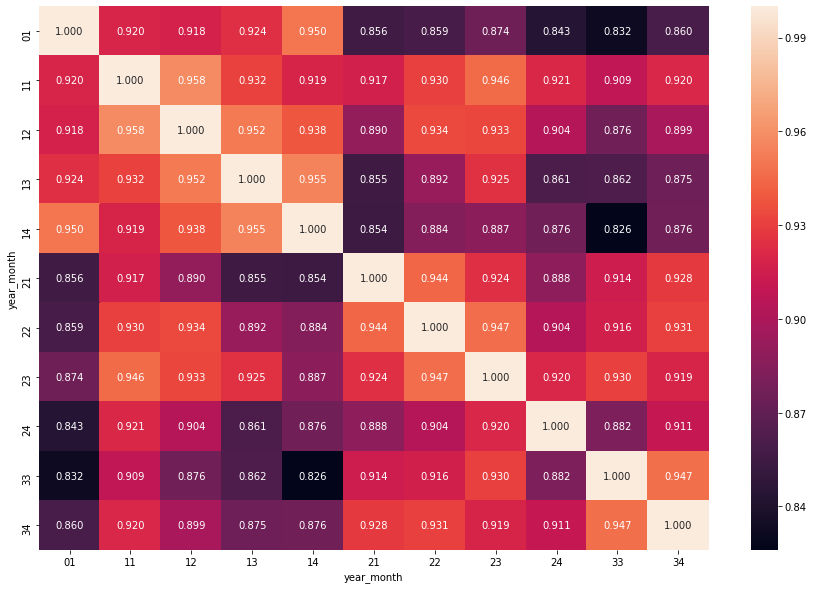

In [0]:
ee = train.groupby(['year','quarter','month','store_id']).sum()[['amount']].reset_index()
ee['year'] = np.where(ee['month']==12, ee['year']-1, ee['year'])
ee['year_month'] = ee['year'].astype('str') + ee['quarter'].astype('str') 
ee = ee.groupby(['year_month','store_id']).sum()[['amount']].reset_index()
ee_rr = ee.pivot(index='store_id', columns='year_month', values='amount')
plt.figure(figsize=(15,10))
sns.heatmap(ee_rr.corr(), annot=True, fmt='.3f')

# 예측

In [0]:
#train3.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_complited_mean.csv', index=False)
train3 = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/train_complited_mean.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
input_var = list(set(train3.columns) - set(['store_id','next_amt','year','region']))
target = 'next_amt'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3','quarter']
log_col = []
for col in input_var:
  try:
    if train3[col].mean() > 100000:
      log_col.append(col)
  except:
    pass

In [0]:
X_test = train3[train3['year_quarter']==10][input_var]
X_test_id = train3[train3['year_quarter']==10][['store_id']]
X = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0)][input_var]
'''for col in log_col:
       X[col] = np.log(X[col]+1)
       X_test[col] = np.log(X_test[col]+1)'''
#X = X.fillna(-9)
y = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0)][target]
#y = np.log(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0)][target]+1)

In [0]:
X.shape, y.shape

((18419, 175), (18419,))

In [0]:
 for i in enumerate (cat_col) : 
      ca = i[1] 
      X[ca] = X[ca].astype('category') 
      X_test[ca] = X_test[ca].astype('category') 

# 베이지안

In [0]:
!pip install Bayesian-Optimization

  Created wheel for Bayesian-Optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=cdddc3b0e83370a167d5a85ed86c75234c5fb3b0be57cbffd9f803f56ea128c5
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built Bayesian-Optimization


In [0]:
from bayes_opt import BayesianOptimization

def LGB_bayesian(
    #learning_rate,
    num_leaves, 
    bagging_fraction,
    feature_fraction,
    min_child_weight, 
    min_data_in_leaf,
    max_depth,
    lambda_l1,
    lambda_l2,
    learning_rate,
    bagging_freq
     ):
    
    # LightGBM expects next three parameters need to be integer. 
    num_leaves = int(num_leaves)
    min_data_in_leaf = int(min_data_in_leaf)
    max_depth = int(max_depth)
    bagging_freq = int(bagging_freq)

    assert type(num_leaves) == int
    assert type(min_data_in_leaf) == int
    assert type(max_depth) == int
    assert type(bagging_freq) == int

    param = {
              'num_leaves': int(round(num_leaves)), 
              'min_data_in_leaf': int(round(min_data_in_leaf)),
              'min_child_weight': min_child_weight,
              'bagging_fraction' : bagging_fraction,
              'feature_fraction' : feature_fraction,
              'learning_rate' : learning_rate,
              'max_depth': int(round(max_depth)),
              'lambda_l1': lambda_l1,
              'lambda_l2': lambda_l2,
              'bagging_freq ':int(round(bagging_freq)),
             'n_estimators': 50000,
              'objective': 'regression_l1',
              'save_binary': True,
              'seed': 42,
              'feature_fraction_seed': 42,
              'bagging_seed': 42,
              'drop_seed': 42,
              'data_random_seed': 42,
              'boosting_type': 'gbdt',
              'verbose': 1,
              'boost_from_average': True,
              'metric':'mae'}    
    folds = KFold(n_splits=5, random_state=42)
    folds_generator = folds.split(X, y.values)
    
    
    cv_result = lgb.cv(param, train_data, folds=folds_generator, seed= 42, stratified=False, verbose_eval =1000, metrics=['mae'],
                       early_stopping_rounds=1000)
    return min(cv_result['l1-mean'])*(-1)

In [0]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (10, 151*3), # 크면 오버핏
    'min_data_in_leaf': (20, 600), # 작으면 오버핏
    'bagging_freq': (1,10),
    'bagging_fraction' : (0.0001, 0.6),
    'feature_fraction' : (0.0001, 0.6),
    'min_child_weight': (0.0001, 0.01), # 크면 오버핏
    #'min_split_gain': (0.001, 0.1),
    'lambda_l1': (0.00001, 10), 
    'lambda_l2': (0.00001, 10),
    'max_depth':(5,151*3),
    'learning_rate': (0.01,0.001)
   # 'n_estimator' : (10000.20000),

}

In [0]:
import warnings
LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=42)
train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)

init_points = 10
n_iter = 100

print('-' * 130)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.01, alpha=1e-6)

----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | baggin... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_da... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[1000]	cv_agg's l1: 0.0663869 + 0.0102476
[2000]	cv_agg's l1: 0.054864 + 0.00806798
[3000]	cv_agg's l1: 0.0513646 + 0.00722906
[4000]	cv_agg's l1: 0.0498368 + 0.00696904
[5000]	cv_agg's l1: 0.0489208 + 0.00679537
[6000]	cv_agg's l1: 0.0483214 + 0.00669033
[7000]	cv_agg's l1: 0.047901 + 0.00661017
[8000]	cv_agg's l1: 0.0475873 + 0.00656439
[9000]	cv_agg's l1: 0.0473392 + 0.0065306
[10000]	cv_agg's l1: 0.0471308 + 0.00650285
[11000]	cv_agg's l1: 0.0469636 + 0.00648277
[12000]	cv_agg's l1: 0.0468213 + 0.00646078
[13000]	cv_agg's l1: 0.0467002 + 0.00644574
[14000]	cv_agg's l

KeyboardInterrupt: ignored

In [0]:
# 3lag
LGB_BO.max['params'], LGB_BO.max['target']

({'bagging_fraction': 0.5817538181959586,
  'bagging_freq': 7.976195410250031,
  'feature_fraction': 0.563705415044357,
  'lambda_l1': 8.948274556002984,
  'lambda_l2': 5.979003809111063,
  'learning_rate': 0.0017031318847919481,
  'max_depth': 44.644640919259935,
  'min_child_weight': 0.0020402303379495374,
  'min_data_in_leaf': 46.23182756811208,
  'num_leaves': 154.1213365281261},
 -0.026032988034967276)

# RFE

In [0]:
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder

for col in tqdm_notebook(X.columns): 
    if col in cat_col:
        le = LabelEncoder()
        le.fit(list(X[col].astype(str).values)+ list(X_test[col].astype(str).values))
        X[col] = le.transform(list(X[col].astype(str).values))
        X_test[col] = le.transform(list(X_test[col].astype(str).values))

In [0]:
from sklearn.metrics import SCORERS
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [0]:
# 21.486282948216125
params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645,
  'n_estimators': 20000}
#params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['bagging_freq'] = int(round(params['bagging_freq']))
params['max_depth'] = int(round(params['max_depth']))
params['objective'] = 'regression_l1'
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

In [0]:
from sklearn.feature_selection import RFECV

clf = lgb.LGBMRegressor(**params) 
dtrain = lgb.Dataset(X, label=y)
rfe = RFECV(estimator=clf, step=1, cv=KFold(5), scoring='neg_mean_absolute_error', verbose=2)
rfe.fit(X, y)

Fitting estimator with 143 features.
Fitting estimator with 142 features.


KeyboardInterrupt: ignored

In [0]:
plt.figure(figsize=(14, 8))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

# Permutation Importance

In [0]:
!pip install eli5

In [0]:
import eli5
from eli5.sklearn import PermutationImportance
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645}
#params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['bagging_freq'] = int(round(params['bagging_freq']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 1000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47


n_splits = 5
folds = KFold(n_splits=n_splits)

for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

    model = lgb.LGBMRegressor(**params, 
                      early_stopping_rounds=500, eval_metric='mae',
                        verbose_eval=500,
                        categorical_feature = cat_col).fit(X.iloc[trn_idx],y.iloc[trn_idx], eval_metric='mae', eval_set=(X.iloc[test_idx],y.iloc[test_idx]) )
    X_valid = X.iloc[test_idx]
    y_valid = y.iloc[test_idx]
    for i in enumerate (cat_col) : 
      ca = i[1] 
      X_valid[ca] = X_valid[ca].astype('category') 

    perm = PermutationImportance(model, random_state=1,).fit(X_valid, y_valid)
    eli5.show_weights(perm, feature_names = X.iloc[test_idx].columns.tolist())

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's l1: 0.82565
Training until validation scores don't improve for 500 rounds.
[2]	valid_0's l1: 0.825061
[3]	valid_0's l1: 0.824467
[4]	valid_0's l1: 0.823875
[5]	valid_0's l1: 0.823285
[6]	valid_0's l1: 0.82275
[7]	valid_0's l1: 0.822158
[8]	valid_0's l1: 0.821631
[9]	valid_0's l1: 0.821078
[10]	valid_0's l1: 0.820543
[11]	valid_0's l1: 0.819989
[12]	valid_0's l1: 0.81943
[13]	valid_0's l1: 0.818842
[14]	valid_0's l1: 0.818248
[15]	valid_0's l1: 0.817724
[16]	valid_0's l1: 0.817119
[17]	valid_0's l1: 0.816592
[18]	valid_0's l1: 0.816054
[19]	valid_0's l1: 0.815474
[20]	valid_0's l1: 0.81495
[21]	valid_0's l1: 0.814376
[22]	valid_0's l1: 0.813813
[23]	valid_0's l1: 0.813263
[24]	valid_0's l1: 0.812681
[25]	valid_0's l1: 0.812097
[26]	valid_0's l1: 0.811518
[27]	valid_0's l1: 0.810935
[28]	valid_0's l1: 0.81035
[29]	valid_0's l1: 0.809763
[30]	valid_0's l1: 0.809183
[31]	valid_0's l1: 0.808604
[32]	valid_0's l1: 0.808033
[33]	valid_0's l1: 0.807506
[34]	valid_0's l1: 0.806979

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: ignored

# 후진 제거
- lag 변수 없이 후진제거를 통해 변수 선택

In [0]:
X.columns

Index(['open_0', 'num_card_id', 'type_of_business3', 'type_of_business',
       'num_comp_a', 'amt_per_region2', 'min_price', 'mean_purchase',
       'num_comp_g', 'amt_per_business3', 'comp_mean_amt_b', 'num_comp_d',
       'open_5', 'open_time_0', 'open_time_2', 'open_time_1', 'region3',
       'regular', 'comp_mean_amt_g', 'regular_amt', 'is_holiday',
       'comp_mean_amt_a', 'amount', 'comp_mean_amt_h', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'weekend_store', 'num_comp_h', 'num_comp_e',
       'amount_per_card', 'quarter_amt', 'num_comp_c', 'comp_mean_amt_f',
       'refund', 'is_point', 'year_quarter', 'business3_amt',
       'installment_term', 'region2', 'open_time_3', 'open_6', 'seasonal_p',
       'num_comp_f', 'amt_per_quarter', 'num_comp_b', 'quarter',
       'action_per_day', 'comp_mean_amt_e', 'region2_amt'],
      dtype='object')

In [0]:
# 제거하는 컬럼 리스트
drop_columns = list()
dropped_values = list()
CVs = list()
drop_max_columns = -1   # -1 is for: repeat until all but one columns are dropped
dset = X.drop(['open_0'], axis=1) # 의미 없는 컬럼 제거, 제거 전: 0.2875
if drop_max_columns == -1:
    drop_max_columns = dset.shape[1] - 1
if drop_max_columns > dset.shape[1]:
    drop_max_columns = dset.shape[1] - 1

params = {'bagging_fraction': 0.5038570668449,
  'bagging_freq': 8.486960589497166,
  'feature_fraction': 0.47699638946138195,
  'lambda_l1': 0.006560528966380461,
  'lambda_l2': 9.20408809999494,
  'learning_rate': 0.001,
  'max_depth': 49.525651162915786,
  'min_child_weight': 0.003526505780170041,
  'min_data_in_leaf': 25.09016719850461,
  'num_leaves': 339.0246460195645}
#params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['bagging_freq'] = int(round(params['bagging_freq']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 20000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47

n_estimators = 20000                                                                                                                                                 
verbose = 5000                                                                                                                                                             
early_stopping_rounds =500 

In [0]:
from time import time
N_folds = 5
cat_col2 = cat_col.copy() # 카테고르 변수 리스트 복사 
dropped_already = -1

allowed_time = 7.5 * 60 * 60 * 60
start_time = time()
current_time = time()
while dropped_already < drop_max_columns and (current_time - start_time) < allowed_time:
    CV = 0
    feature_importance = pd.DataFrame() 
    kf = KFold(n_splits=N_folds) # random_state=312, shuffle=True
    fold_n = 0
    for i,(train_index, valid_index) in enumerate(kf.split(dset,y)):
        X_train, X_valid = dset.drop(drop_columns, axis=1).iloc[train_index], dset.drop(drop_columns, axis=1).iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        dtrain = lgb.Dataset(X_train, label=y_train)
        dvalid = lgb.Dataset(X_valid, label=y_valid)
        model = lgb.train(params, dtrain, n_estimators, valid_sets=[dtrain, dvalid], verbose_eval=verbose, 
                          early_stopping_rounds=early_stopping_rounds ,categorical_feature =cat_col2)
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = dset.drop(drop_columns, axis=1).columns                                                                                                                                     
        fold_importance["importance"] = model.feature_importance()                                                                                                              
        fold_importance["fold"] = fold_n + 1                  
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)                                                                                        
        CV += model.best_score["valid_1"]["l1"] 
        fold_n += 1

    CV /= N_folds
    fi = pd.DataFrame({"Feature":feature_importance.pivot(index="fold", columns="feature", values="importance").columns.values,                                   
                      "Value":feature_importance.pivot(index="fold", columns="feature", values="importance").mean().values})
    row = fi.iloc[fi['Value'].idxmin()]
    feature = row["Feature"]
    print('*************** Mean AUC:', CV, ', ', X_train.shape, ', ',feature)
    value = row["Value"]
    drop_columns.append(feature)
    dropped_values.append(value)
    if feature in cat_col2: # 카테고리 변수 리스트도 업데이트
      cat_col2.remove(feature)
    CVs.append(CV)
    dropped_already += 1
    current_time = time()

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['quarter', 'region2', 'region3', 'type_of_business', 'type_of_business3']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.245387	valid_1's l1: 0.302714
[10000]	training's l1: 0.204742	valid_1's l1: 0.297085
[15000]	training's l1: 0.185106	valid_1's l1: 0.295468
Early stopping, best iteration is:
[18552]	training's l1: 0.175379	valid_1's l1: 0.294158
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.24589	valid_1's l1: 0.294465
[10000]	training's l1: 0.204821	valid_1's l1: 0.289686
[15000]	training's l1: 0.185439	valid_1's l1: 0.288348
[20000]	training's l1: 0.17194	valid_1's l1: 0.287701
Did not meet early stopping. Best iteration is:
[20000]	training's l1: 0.17194	valid_1's l1: 0.287701
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.244059	valid_1's l1: 0.298897
[10000]	training's l1: 0.202451	valid_1's l1: 0.295378
Early stopping, best iteration is:
[9572]	training's l1: 0.204716	valid_1's l1: 0.295335
Training until validation scores don't i

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['quarter', 'region2', 'region3', 'type_of_business']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[5000]	training's l1: 0.245441	valid_1's l1: 0.302933
[10000]	training's l1: 0.204823	valid_1's l1: 0.297335
Early stopping, best iteration is:
[11666]	training's l1: 0.196794	valid_1's l1: 0.296405
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.246009	valid_1's l1: 0.294451
[10000]	training's l1: 0.204897	valid_1's l1: 0.289701
[15000]	training's l1: 0.185165	valid_1's l1: 0.288369
[20000]	training's l1: 0.172164	valid_1's l1: 0.287764
Did not meet early stopping. Best iteration is:
[20000]	training's l1: 0.172164	valid_1's l1: 0.287764
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.244305	valid_1's l1: 0.298958
Early stopping, best iteration is:
[9243]	training's l1: 0.206935	valid_1's l1: 0.295438
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.232409	valid_1's l1: 0.379526
[10000]	training's l1: 0.193787	valid_1's l1: 0.372734
[15000]	training's l1: 0.175173	valid_

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['quarter', 'region2', 'region3']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[5000]	training's l1: 0.245283	valid_1's l1: 0.302674
[10000]	training's l1: 0.204704	valid_1's l1: 0.297314
Early stopping, best iteration is:
[12170]	training's l1: 0.194656	valid_1's l1: 0.296189
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.245828	valid_1's l1: 0.294444
[10000]	training's l1: 0.204891	valid_1's l1: 0.28979
[15000]	training's l1: 0.185724	valid_1's l1: 0.288528
Early stopping, best iteration is:
[18564]	training's l1: 0.175903	valid_1's l1: 0.288119
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.244147	valid_1's l1: 0.298886
[10000]	training's l1: 0.202602	valid_1's l1: 0.295487
Early stopping, best iteration is:
[12896]	training's l1: 0.189396	valid_1's l1: 0.294969
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.232116	valid_1's l1: 0.379167
[10000]	training's l1: 0.193483	valid_1's l1: 0.372508
[15000]	training's l1: 0.175069	valid_1's l1: 0.371

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['quarter', 'region3']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[5000]	training's l1: 0.245788	valid_1's l1: 0.302739
[10000]	training's l1: 0.205067	valid_1's l1: 0.297127
Early stopping, best iteration is:
[11416]	training's l1: 0.198195	valid_1's l1: 0.296436
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.246316	valid_1's l1: 0.29468
[10000]	training's l1: 0.20529	valid_1's l1: 0.290018
[15000]	training's l1: 0.186221	valid_1's l1: 0.288748
[20000]	training's l1: 0.17286	valid_1's l1: 0.288244
Did not meet early stopping. Best iteration is:
[20000]	training's l1: 0.17286	valid_1's l1: 0.288244
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.244628	valid_1's l1: 0.298779
[10000]	training's l1: 0.202872	valid_1's l1: 0.295407
Early stopping, best iteration is:
[9599]	training's l1: 0.205055	valid_1's l1: 0.295359
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.232418	valid_1's l1: 0.379166
[10000]	training's l1: 0.193845	valid_1's 

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['quarter']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[5000]	training's l1: 0.245115	valid_1's l1: 0.301385
[10000]	training's l1: 0.204467	valid_1's l1: 0.296352
Early stopping, best iteration is:
[12452]	training's l1: 0.193315	valid_1's l1: 0.29523
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.245526	valid_1's l1: 0.293906
[10000]	training's l1: 0.204322	valid_1's l1: 0.289879
[15000]	training's l1: 0.185374	valid_1's l1: 0.288956
Early stopping, best iteration is:
[18610]	training's l1: 0.17564	valid_1's l1: 0.288434
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.243854	valid_1's l1: 0.298641
Early stopping, best iteration is:
[9008]	training's l1: 0.207896	valid_1's l1: 0.295868
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.232189	valid_1's l1: 0.37763
[10000]	training's l1: 0.193668	valid_1's l1: 0.371059
[15000]	training's l1: 0.175112	valid_1's l1: 0.369714
Early stopping, best iteration is:
[15011]	training's 

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[5000]	training's l1: 0.246789	valid_1's l1: 0.30339
[10000]	training's l1: 0.206076	valid_1's l1: 0.298868
Early stopping, best iteration is:
[12438]	training's l1: 0.194964	valid_1's l1: 0.2981
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.247522	valid_1's l1: 0.296826
[10000]	training's l1: 0.206216	valid_1's l1: 0.293268
Early stopping, best iteration is:
[12078]	training's l1: 0.196435	valid_1's l1: 0.292759
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.245886	valid_1's l1: 0.301228
Early stopping, best iteration is:
[8930]	training's l1: 0.210297	valid_1's l1: 0.298516
Training until validation scores don't improve for 500 rounds.
[5000]	training's l1: 0.233808	valid_1's l1: 0.380075
[10000]	training's l1: 0.195226	valid_1's l1: 0.373342
[15000]	training's l1: 0.176901	valid_1's l1: 0.371967
Early stopping, best iteration is:
[15289]	training's l1: 0.175966	valid_1's l1: 0.371939
Training until vali

In [0]:
drop_columns = drop_columns[:-1]
dropped_values = dropped_values[:-1]
drop_columns.insert(0, "Nothing")
dropped_values.insert(0, 0)
deltas = list(np.array(CVs)[:-1] - np.array(CVs)[1:])
deltas.insert(0, 0)
df = pd.DataFrame({"Dropped_feature":drop_columns, "CV_change":deltas, "N_dropped":np.arange(len(CVs)), "CV":CVs})
#df.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/EDA/직접후진제거.csv")

In [0]:
from bokeh.models import HoverTool
from bokeh.io import output_notebook
from bokeh.plotting import figure, show

output_notebook()

fig = figure(plot_height=700,
             plot_width=900,
             x_axis_label='Number of dropped features',
             x_range=(0, drop_max_columns),
             y_axis_label='AUC',
             title='AUC vs number of dropped features',
             toolbar_location='below',
             tools='save, box_zoom, pan, wheel_zoom, reset')

tooltips = [
            ('Dropped feature','@Dropped_feature'),
            ('CV change', '@CV_change'),
            ("Number of dropped features", "@N_dropped"),
            ("Current CV", "@CV")
           ]

scatter = fig.circle(x='N_dropped', y='CV', source=df,
        size=15, alpha=1,
        hover_fill_color='cyan', hover_alpha=0.3)

fig.add_tools(HoverTool(tooltips=tooltips, renderers=[scatter]))

show(fig)

#예측

In [0]:
!git clone --recurse-submodules https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build

Cloning into 'LightGBM'...
remote: Enumerating objects: 15527, done.
remote: Total 15527 (delta 0), reused 0 (delta 0), pack-reused 15527
Receiving objects: 100% (15527/15527), 10.55 MiB | 18.69 MiB/s, done.
Resolving deltas: 100% (11238/11238), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'
/content/LightGBM
mkdir: cannot create directory ‘build’: File exists


In [0]:
!git clone --recurse-submodules https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1 /content/LightGBM/
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy "scikit-learn<=0.21.3" -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile
#%cd /content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/EDA

fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM
mkdir: cannot create directory ‘build’: File exists
-- OpenCL include directory: /usr/include
-- Boost version: 1.65.1
-- Found the following Boost libraries:
--   filesystem
--   system
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM
[ 95%] Built target lightgbm
[100%] Built target _lightgbm
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-pip is already the newest version (9.0.1-2.3~ubuntu1.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (42.0.2)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.25.3)
Requirem

In [0]:
from time import time
import datetime
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
params = {'bagging_fraction': 0.5817538181959586,
  'bagging_freq': 7.976195410250031,
  'feature_fraction': 0.563705415044357,
  'lambda_l1': 8.948274556002984,
  'lambda_l2': 5.979003809111063,
  'learning_rate': 0.0017031318847919481,
  'max_depth': 44.644640919259935,
  'min_child_weight': 0.0020402303379495374,
  'min_data_in_leaf': 46.23182756811208,
  'num_leaves': 154.1213365281261,
  'use_missing': True,
  'device_type':'gpu'}
#params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['bagging_freq'] = int(round(params['bagging_freq']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47


CV= []
iteration=[]
evals_result = {}
evals_results = []
X_test_id['amount'] = 0
n_splits = 5
folds = KFold(n_splits=n_splits)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
training_start_time = time()

## 2. 1분기 데이터를 valid로 사용
X_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][input_var]
#y_train = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
#                 (train3.year_quarter<9)][target]
y_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][target]              
X_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][input_var]
#y_valid = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
#                 (train3.year_quarter==9)][target])
y_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][target]

'''for col in log_col:
       X_train[col] = np.log1p(X_train[col])
       X_valid[col] = np.log(X_test[col])'''
# 범주형을 category로 타입변경
for i in enumerate (cat_col) : 
    ca = i[1] 
    X_train[ca] = X_train[ca].astype('category') 
    X_valid[ca] = X_valid[ca].astype('category') 


for fold, (trn_idx, test_idx) in enumerate(folds.split(X_valid, y_valid)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    # valid를 kfold 내에서 검증용과 훈련용으로 나눔
    X1_valid, X2_valid = X_valid.iloc[trn_idx], X_valid.iloc[test_idx]
    y1_valid, y2_valid = y_valid.iloc[trn_idx], y_valid.iloc[test_idx]
    # X1_valid는 훈련용으로 다시 합침
    X2_train = pd.concat([X_train, X1_valid], axis=0)
    y2_train = pd.concat([y_train, y1_valid], axis=0)

    for i in enumerate (cat_col) : 
      ca = i[1] 
      X2_train[ca] = X2_train[ca].astype('category') 

    trn_data = lgb.Dataset(X2_train, label=y2_train)
    val_data = lgb.Dataset(X2_valid, label=y2_valid)

    model = lgb.train(params, trn_data, 200000, valid_sets=[trn_data, val_data],
                      early_stopping_rounds=500,
                        verbose_eval=1000,
                        categorical_feature = cat_col)
    feature_importances['fold_{}'.format(fold + 1)] = model.feature_importance(importance_type='gain')
    CV.append(model.best_score['valid_1']['l1'])
# Predict
    X_test_id['amount'] += model.predict(X_test)
X_test_id['amount'] = np.exp(X_test_id['amount'] / n_splits) 
#X_test_id['amount'] = (X_test_id['amount'] / n_splits) * 3

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('CV mean {}, CV std {}'.format(np.mean(CV), np.std(CV)))
print('-' * 30)

Training on fold 1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['quarter', 'region2', 'region3', 'type_of_business', 'type_of_business3']
  return self


LightGBMError: ignored

In [0]:
from time import time
import datetime
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit
params = {'bagging_fraction': 0.5817538181959586,
  'bagging_freq': 7.976195410250031,
  'feature_fraction': 0.563705415044357,
  'lambda_l1': 8.948274556002984,
  'lambda_l2': 5.979003809111063,
  'learning_rate': 0.0017031318847919481,
  'max_depth': 44.644640919259935,
  'min_child_weight': 0.0020402303379495374,
  'min_data_in_leaf': 46.23182756811208,
  'num_leaves': 154.1213365281261,
  'use_missing': True,
 # 'use_gpu':True
  }
#params = LGB_BO.max['params']
params['num_leaves'] = int(round(params['num_leaves']))
params['min_data_in_leaf'] = int(round(params['min_data_in_leaf']))
params['max_depth'] = int(round(params['max_depth']))
params['bagging_freq'] = int(round(params['bagging_freq']))
params['objective'] = 'regression_l1'
params['n_estimators ']= 100000,
params['metric'] = 'mae'
params['verbose'] = -1
params['boosting_type'] = 'gbdt'
params['random_state'] = 47


CV= []
iteration=[]
evals_result = {}
evals_results = []
X_test_id['amount'] = 0
n_splits = 5
folds = KFold(n_splits=n_splits)

feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns
training_start_time = time()

## 2. 1분기 데이터를 valid로 사용
X_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][input_var]
#y_train = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
#                 (train3.year_quarter<9)][target]
y_train = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter<9)][target]              
X_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][input_var]
#y_valid = np.log1p(train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
#                 (train3.year_quarter==9)][target])
y_valid = train3[(train3.next_amt.isna()==False) & (train3.next_amt>0) &
                 (train3.year_quarter==9)][target]

'''for col in log_col:
       X_train[col] = np.log1p(X_train[col])
       X_valid[col] = np.log(X_test[col])'''
# 범주형을 category로 타입변경
for i in enumerate (cat_col) : 
    ca = i[1] 
    X_train[ca] = X_train[ca].astype('category') 
    X_valid[ca] = X_valid[ca].astype('category') 


for fold, (trn_idx, test_idx) in enumerate(folds.split(X_valid, y_valid)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    # valid를 kfold 내에서 검증용과 훈련용으로 나눔
    X1_valid, X2_valid = X_valid.iloc[trn_idx], X_valid.iloc[test_idx]
    y1_valid, y2_valid = y_valid.iloc[trn_idx], y_valid.iloc[test_idx]
    # X1_valid는 훈련용으로 다시 합침
    X2_train = pd.concat([X_train, X1_valid], axis=0)
    y2_train = pd.concat([y_train, y1_valid], axis=0)

    for i in enumerate (cat_col) : 
      ca = i[1] 
      X2_train[ca] = X2_train[ca].astype('category') 

    trn_data = lgb.Dataset(X2_train, label=y2_train)
    val_data = lgb.Dataset(X2_valid, label=y2_valid)

    model = lgb.train(params, trn_data, 200000, valid_sets=[trn_data, val_data],
                      early_stopping_rounds=500,
                        verbose_eval=1000,
                        categorical_feature = cat_col)
    feature_importances['fold_{}'.format(fold + 1)] = model.feature_importance(importance_type='gain')
    CV.append(model.best_score['valid_1']['l1'])
# Predict
    X_test_id['amount'] += model.predict(X_test)
X_test_id['amount'] = np.exp(X_test_id['amount'] / n_splits) 
#X_test_id['amount'] = (X_test_id['amount'] / n_splits) * 3

print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('CV mean {}, CV std {}'.format(np.mean(CV), np.std(CV)))
print('-' * 30)

Training on fold 1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['quarter', 'region2', 'region3', 'type_of_business', 'type_of_business3']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 294904	valid_1's l1: 203185
[2000]	training's l1: 144679	valid_1's l1: 79493
[3000]	training's l1: 93833.5	valid_1's l1: 48329.6
[4000]	training's l1: 70316.3	valid_1's l1: 33894.9
[5000]	training's l1: 62425.4	valid_1's l1: 30237.4
[6000]	training's l1: 57779.5	valid_1's l1: 27722.3
[7000]	training's l1: 55031.5	valid_1's l1: 26038.1
[8000]	training's l1: 52880	valid_1's l1: 24731.3
[9000]	training's l1: 51117.4	valid_1's l1: 23650
[10000]	training's l1: 49905.8	valid_1's l1: 23215.1
[11000]	training's l1: 48580.5	valid_1's l1: 23027
Early stopping, best iteration is:
[10525]	training's l1: 49254	valid_1's l1: 22979
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's l1: 293497	valid_1's l1: 315549
[2000]	training's l1: 144109	valid_1's l1: 141599
[3000]	training's l1: 93530.2	valid_1's l1: 79084.7
[4000]	training's l1: 69789.7	valid_1's l1: 57184.2
[500

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
# 시간 24, 12시간 비교
(22597.8 + 28982.5+ 22454.7+140042+46377.8) / 5

52090.96

In [0]:
print('CV mean {}, CV std {}'.format(np.mean(CV), np.std(CV)))

CV mean nan, CV std nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [0]:
CV mean 57846.14503819177, CV std 41438.66699940352

In [0]:
print('CV mean {}, CV std {}'.format(np.mean(CV), np.std(CV)))

CV mean 58367.12528194834, CV std 41609.425636719345


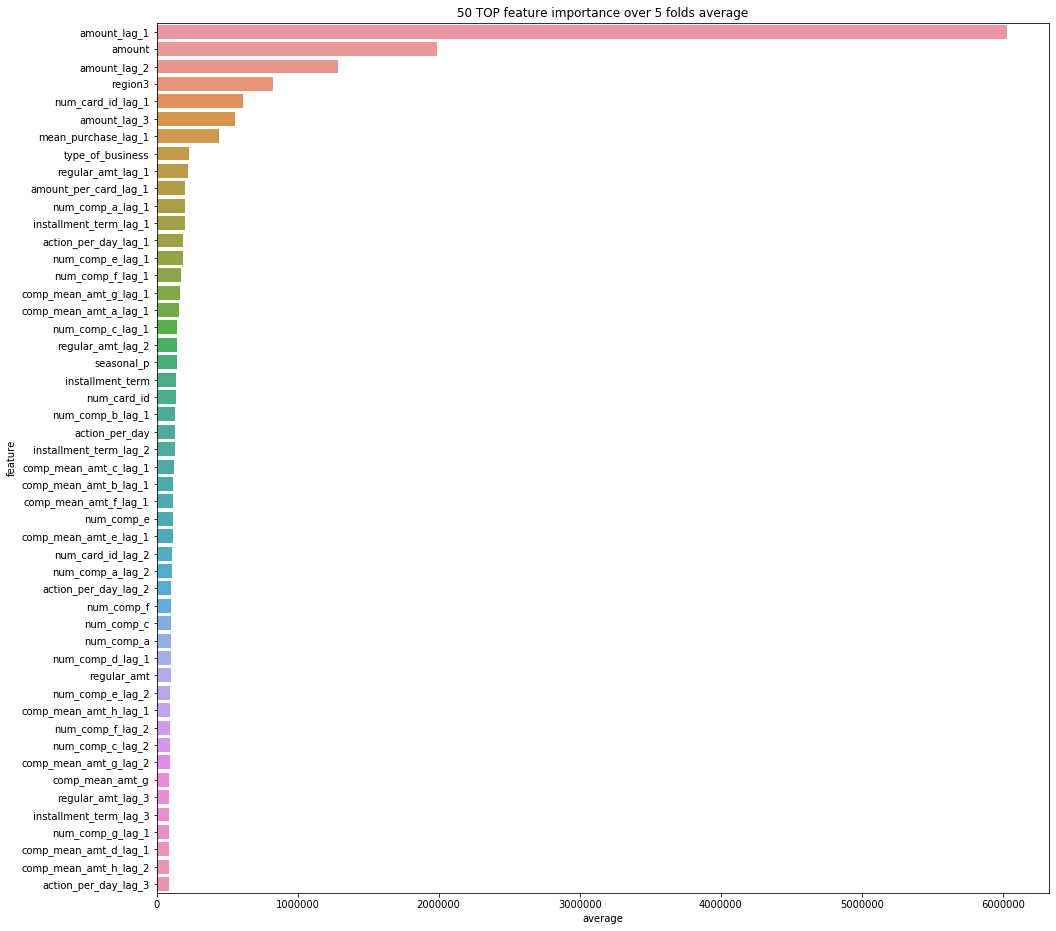

In [0]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [0]:
submission = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Data/submission.csv')
train = pd.read_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Preprocessing/funda_train_prep.csv')

In [0]:
rest_store = list(set(train.store_id.unique()) - set(train[((train['year']==2019) & (train['month']<=2)) | ((train['year']==2018) & (train['month']==12))].store_id.unique())) # 19년 1분기 매출이 없는 가게
rest_2018_1 = train3.loc[(train3['store_id'].isin(rest_store)) & (train3['quarter']==2) & (train3['year']==2018)][['store_id','amount']] # 18년 2분기로 대체
rest_list1 = set(rest_store) - set(rest_2018_1.store_id.unique())
rest_2018_2 = train3.loc[(train3['store_id'].isin(rest_list1)) & (train3['quarter']==2) & (train3['year']==2017)][['store_id','amount']] # 17년 2분기로 대체
reset_st = pd.concat([rest_2018_1, rest_2018_2], axis=0)
reset_st['amount'] = reset_st['amount']*3

In [0]:
#X_test_id['amount'] = np.exp(model.predict(X_test))

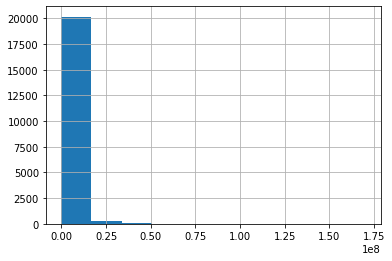

In [0]:
(train3['amount']*3).hist()

In [0]:
X_test_id = pd.concat([X_test_id, reset_st], axis=0)

In [0]:
submission2 = pd.merge(submission.drop('amount',axis=1),X_test_id, on='store_id')

In [0]:
'''
input_var (평균변수)= ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] + 3 lag
target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.5817538181959586,
  'bagging_freq': 7.976195410250031,
  'feature_fraction': 0.563705415044357,
  'lambda_l1': 8.948274556002984,
  'lambda_l2': 5.979003809111063,
  'learning_rate': 0.0017031318847919481,
  'max_depth': 44.644640919259935,
  'min_child_weight': 0.0020402303379495374,
  'min_data_in_leaf': 46.23182756811208,
  'num_leaves': 154.1213365281261,
  'use_missing': True}

rest_store = list(set(train.store_id.unique()) - set(train[((train['year']==2019) & (train['month']<=2)) | ((train['year']==2018) & (train['month']==12))].store_id.unique()))
rest_2018_1 = train3.loc[(train3['store_id'].isin(rest_store)) & (train3['quarter']==1) & (train3['year']==2018)][['store_id','amount']]
rest_list1 = set(rest_store) - set(rest_2018_1.store_id.unique())
rest_2018_2 = train3.loc[(train3['store_id'].isin(rest_list1))][['store_id']].drop_duplicates()
rest_2018_2['amount'] = 0 # 이 가게들을 16~18년까지 1분기 매출만 없음
reset_st = pd.concat([rest_2018_1, rest_2018_2], axis=0)


score = 1064768.174520
'''



submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1220_3lag_mean.csv',index=False)

In [0]:
'''
input_var (평균변수)= ['installment_term', 'amount',
       'is_holiday', 'is_point', 'refund', 'region2', 'region3',
       'region2_amt', 'amt_per_region2', 'quarter_amt', 'amt_per_quarter',
       'mean_purchase', 'min_price', 'type_of_business', 'type_of_business3',
       'open_time_0', 'open_time_1', 'open_time_2', 'open_time_3',
       'weekend_store', 'open_0', 'open_5', 'open_6', 'seasonal_p',
       'action_per_day', 'num_card_id', 'amount_per_card', 'regular',
       'regular_amt', 'comp_mean_amt_a', 'comp_mean_amt_b', 'comp_mean_amt_c',
       'comp_mean_amt_d', 'comp_mean_amt_e', 'comp_mean_amt_f',
       'comp_mean_amt_g', 'comp_mean_amt_h', 'num_comp_a', 'num_comp_b',
       'num_comp_c', 'num_comp_d', 'num_comp_e', 'num_comp_f', 'num_comp_g',
       'num_comp_h'] + 3 lag
target = 'amount_lag_1'
cat_col = ['region2', 'region3', 'type_of_business','type_of_business3']

params = {'bagging_fraction': 0.5817538181959586,
  'bagging_freq': 7.976195410250031,
  'feature_fraction': 0.563705415044357,
  'lambda_l1': 8.948274556002984,
  'lambda_l2': 5.979003809111063,
  'learning_rate': 0.0017031318847919481,
  'max_depth': 44.644640919259935,
  'min_child_weight': 0.0020402303379495374,
  'min_data_in_leaf': 46.23182756811208,
  'num_leaves': 154.1213365281261,
  'use_missing': True}

rest_store = list(set(train.store_id.unique()) - set(train[((train['year']==2019) & (train['month']<=2)) | ((train['year']==2018) & (train['month']==12))].store_id.unique()))
rest_2018_1 = train3.loc[(train3['store_id'].isin(rest_store)) & (train3['quarter']==1) & (train3['year']==2018)][['store_id','amount']]
rest_list1 = set(rest_store) - set(rest_2018_1.store_id.unique())
rest_2018_2 = train3.loc[(train3['store_id'].isin(rest_list1))][['store_id']].drop_duplicates()
rest_2018_2['amount'] = 0 # 이 가게들을 16~18년까지 1분기 매출만 없음
reset_st = pd.concat([rest_2018_1, rest_2018_2], axis=0)


score = 1070914.813850
'''



submission2.to_csv('/content/drive/My Drive/Data_Science/Dacon/9th 펀다 상점매출 예측/Submission/submission_1220_3lag_mean_raw.csv',index=False)

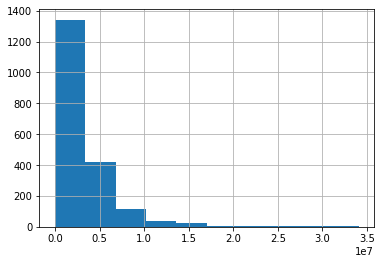

In [0]:
submission2['amount'].hist()

**결과**
- validation에서는 훨씬 MAE가 낮았으나, test에서는 기존 점수에 비해 약 200,000점이나 높은 MAE가 나왔다.
  - 같은 분기라도 월마다 매출 변동이 심해서 그런 것 같다. 